# DC Prediction instead of Average for CfL

In this notebook, we revisit the [chroma from luma prediction](https://github.com/luctrudeau/CfL-Analysis/blob/master/notebooks/exploratory/0.03-luctrudeau-ChromaFromLumaPrediction.ipynb) experiment and compare using the DC prediction instead of using the chroma average. This is required because the chroma sample average is not available to the decoder. We measure the error involved by using DC prediction as an approximation of the chroma pixel average.

In [3]:
%matplotlib inline

# Load the "autoreload" extension so that code can change
%load_ext autoreload

# Always reload modules so that as you change code in src, it gets loaded
%autoreload 2

import load_paths
from src.data import make_kodim

import matplotlib.pyplot as plt
import numpy as np

[kodims, kodim_files] = make_kodim.load_kodim()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Parameters for the experience

In [4]:
# Block size used to compare luma and chroma 
block_size = 32

# Image used
im = kodims[4]

## Predicting U from dY + DC

For each block in the image, we measure the sum of square error when prediction U using:

 * DC prediction
 * U average
 * Chroma from Luma (with DC prediction)
 * Chroma from Luma (with U average)

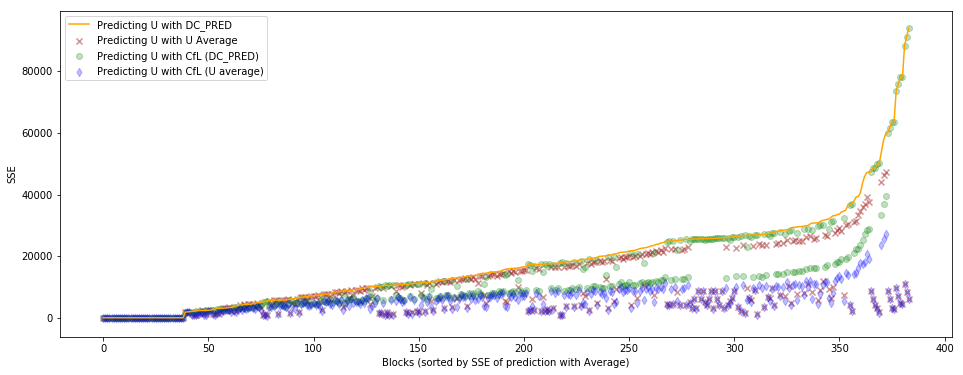

In [52]:
height, width, z = im.shape
plot_width = int(width / block_size)
plot_height = int(height / block_size)

errU = np.zeros((plot_height, plot_width))
avg_errU = np.zeros((plot_height, plot_width))
dc_errU = np.zeros((plot_height, plot_width))
cfl_dc_errU = np.zeros((plot_height, plot_width))

yy = 1
for y in range(block_size, height, block_size):
    xx = 1
    for x in range(block_size, width, block_size):
        above = im[yy-1:yy, xx:xx+block_size, 1]
        left = im[yy:yy+block_size, xx-1:xx, 1]
        dc = np.rint(np.mean([above.ravel(), left.ravel()]))
        
        bY = im[yy:yy+block_size,xx:xx+block_size,0].ravel()
        bU = im[yy:yy+block_size,xx:xx+block_size,1].ravel()
        
        avgY = np.rint(np.mean(bY))
        avgU = np.rint(np.mean(bU))
        
        dY = bY - avgY
        dU = bU - avgU
        
        sY2 = np.sum(dY**2)
        sYU = np.sum(dY*dU)
        
        a = sYU / sY2
        
        errU[yy, xx] = np.sum((bU - (a * dY + avgU))**2)
        cfl_dc_errU[yy, xx] = np.sum((bU - (a * dY + dc))**2)
        avg_errU[yy, xx] = np.sum((bU - avgU)**2)
        dc_errU[yy, xx] = np.sum((bU - dc)**2)

        xx = xx + 1
    yy = yy + 1

plt.figure(figsize=(16,6))
ind = np.argsort(dc_errU.ravel())
r = np.arange(cfl_dc_errU.ravel().size)
plt.plot(dc_errU.ravel()[ind], label='Predicting U with DC_PRED', color='orange');
plt.scatter(r, avg_errU.ravel()[ind], label='Predicting U with U Average', color='brown', alpha=0.5, marker='x');
plt.scatter(r, cfl_dc_errU.ravel()[ind], label='Predicting U with CfL (DC_PRED)', color='green', alpha=0.25, marker='o');
plt.scatter(r, errU.ravel()[ind], label='Predicting U with CfL (U average)', color='blue', alpha=0.25, marker='d');

plt.xlabel("Blocks (sorted by SSE of prediction with Average)")
plt.ylabel("SSE")
plt.legend(loc='best');

The following boxplot shows the minimum, first quartile, median, third quartile and the maximum sum of square error for each predictor.

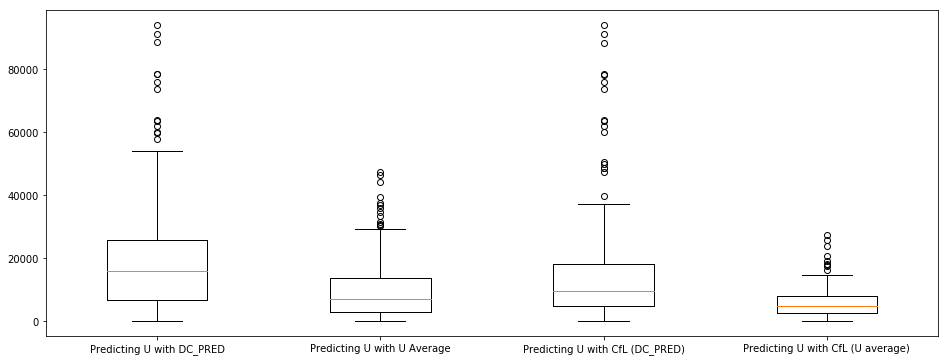

In [60]:
plt.figure(figsize=(16,6))
plt.boxplot((dc_errU.ravel(), avg_errU.ravel(), cfl_dc_errU.ravel(), errU.ravel()),
            labels=['Predicting U with DC_PRED','Predicting U with U Average',
                   'Predicting U with CfL (DC_PRED)','Predicting U with CfL (U average)']);

## Predicting V from dY + DC

For each block in the image, we measure the sum of square error when prediction V using:

 * DC prediction
 * U average
 * Chroma from Luma (with DC prediction)
 * Chroma from Luma (with U average)

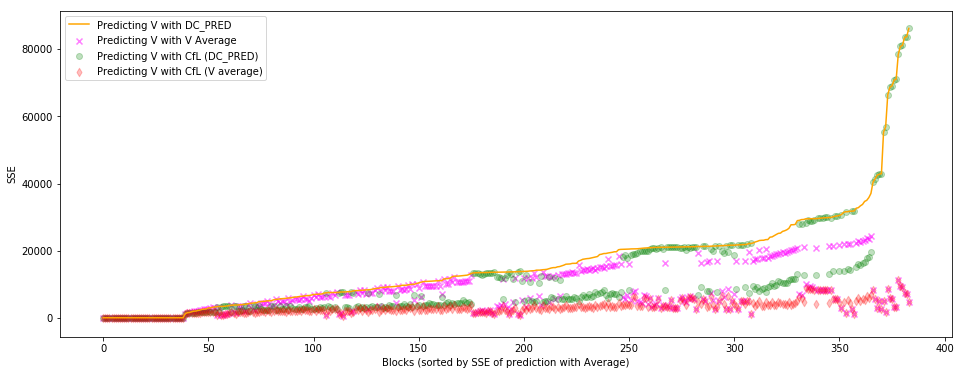

In [53]:
errV = np.zeros((plot_height, plot_width))
avg_errV = np.zeros((plot_height, plot_width))
dc_errV = np.zeros((plot_height, plot_width))
cfl_dc_errV = np.zeros((plot_height, plot_width))

yy = 1
for y in range(block_size, height, block_size):
    xx = 1
    for x in range(block_size, width, block_size):
        above = im[yy-1:yy, xx:xx+block_size, 2]
        left = im[yy:yy+block_size, xx-1:xx, 2]
        dc = np.rint(np.mean([above.ravel(), left.ravel()]))
        
        bY = im[yy:yy+block_size,xx:xx+block_size,0].ravel()
        bV = im[yy:yy+block_size,xx:xx+block_size,2].ravel()
        
        avgY = np.rint(np.mean(bY))
        avgV = np.rint(np.mean(bV))
        
        dY = bY - avgY
        dV = bV - avgV
        
        sY2 = np.sum(dY**2)
        sYV = np.sum(dY*dV)
        
        a = sYV / sY2
        
        errV[yy, xx] = np.sum((bV - (a * dY + avgV))**2)
        cfl_dc_errV[yy, xx] = np.sum((bV - (a * dY + dc))**2)
        avg_errV[yy, xx] = np.sum((bV - avgV)**2)
        dc_errV[yy, xx] = np.sum((bV - dc)**2)

        xx = xx + 1
    yy = yy + 1

plt.figure(figsize=(16,6))
ind = np.argsort(dc_errV.ravel())
r = np.arange(cfl_dc_errV.ravel().size)
plt.plot(dc_errV.ravel()[ind], label='Predicting V with DC_PRED', color='orange');
plt.scatter(r, avg_errV.ravel()[ind], label='Predicting V with V Average', color='magenta', alpha=0.5, marker='x');
plt.scatter(r, cfl_dc_errV.ravel()[ind], label='Predicting V with CfL (DC_PRED)', color='green', alpha=0.25, marker='o');
plt.scatter(r, errV.ravel()[ind], label='Predicting V with CfL (V average)', color='red', alpha=0.25, marker='d');

plt.xlabel("Blocks (sorted by SSE of prediction with Average)")
plt.ylabel("SSE")
plt.legend(loc='best');

The following boxplot shows the minimum, first quartile, median, third quartile and the maximum sum of square error for each predictor.

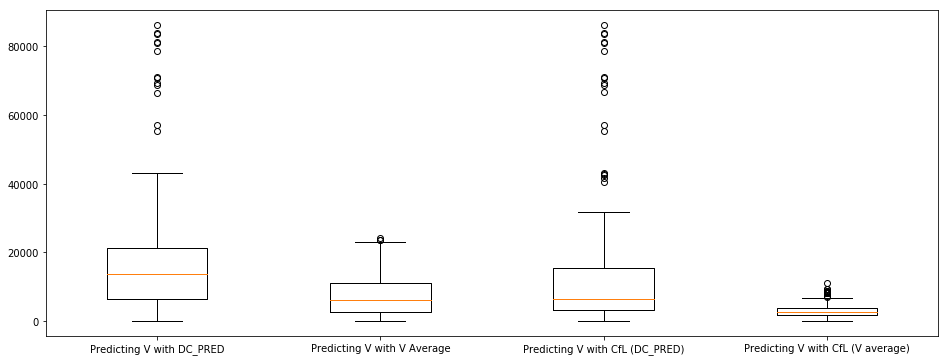

In [61]:
plt.figure(figsize=(16,6))
plt.boxplot((dc_errV.ravel(), avg_errV.ravel(), cfl_dc_errV.ravel(), errV.ravel()),
            labels=['Predicting V with DC_PRED','Predicting V with V Average',
                   'Predicting V with CfL (DC_PRED)','Predicting V with CfL (V average)']);